In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import harmonypy
import pymn
import scrublet as scr
import gseapy as gp
from gseapy.plot import barplot, dotplot
import bottleneck
import pyreadr
from scipy.io import mmread
import scipy
from sklearn import preprocessing
import random as rd
import scib
from matplotlib_venn import venn2,venn2_circles,venn3
from pyscenic.export import export2loom, add_scenic_metadata
from sklearn.decomposition import NMF
from sklearn import metrics
import palettable
from pyscenic.rss import regulon_specificity_scores
import matplotlib.image as mpimg
import cosg as cosg
from pySankey.sankey import sankey

import matplotlib as mpl

from pyscenic.utils import modules_from_adjacencies
from IPython.display import display, Image


In [4]:
sc.set_figure_params(dpi = 200, color_map = 'viridis_r' )
sc.settings.verbosity = 2

# Exon & Intron

In [285]:
#up_inter_deg_list = ['MOK',
# 'DNAH7',
# 'CFAP47',
# 'HYDIN',
# 'ARMC3',
# 'DCDC1',
# 'SPATA17',
# 'C4orf22',
# 'AGBL4',
# 'CFAP54',
# 'CFAP70',
# 'TMEM232',
# 'WDR49',
# 'FAM227A',
# 'DNAH6',
# 'LRRC6',
# 'LRRIQ1',
# 'PACRG',
# 'CFAP46']

each_cancer_marker = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cancer_subtype_marker_DEG/each_cancer_marker_latest.csv', index_col=0)
each_cancer_marker = each_cancer_marker[each_cancer_marker['cluster'] == 10]

inter = pd.DataFrame(each_cancer_marker['gene'].value_counts()).copy()
up_inter_deg_list = inter[inter['gene'] >= 4].index.tolist()

In [286]:
adata_anno = sc.read('cnv_high_low_ciliated.h5ad')
adata = sc.read('cnv_high_low_ciliated.h5ad')
low_cell_list = adata[adata.obs['cnv_cluster_type'] == 'low'].obs.index.tolist()
high_cell_list = adata[adata.obs['cnv_cluster_type'] == 'high'].obs.index.tolist()

In [287]:
all_gene_biotype = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cnv_high_DEG/all_gene_biotype_latest.csv', index_col=0)
all_gene_biotype = all_gene_biotype[all_gene_biotype['biotype_modified'] == 'Protein-coding Gene']

In [288]:
intron_exon = sc.read('ciliated_intron_exon_counts.h5ad')
exon_only = sc.read('ciliated_exon_only_counts.h5ad')

intron_exon = intron_exon[:, list(set(up_inter_deg_list).intersection(set(all_gene_biotype.index.tolist())))]
exon_only = exon_only[:, list(set(up_inter_deg_list).intersection(set(all_gene_biotype.index.tolist())))]

intron_exon = intron_exon.to_df()
exon_only = exon_only.to_df()

In [289]:
stat_all = pd.DataFrame()

up_inter_deg_list = list(set(up_inter_deg_list).intersection(set(all_gene_biotype.index.tolist())))

for i in list(set(up_inter_deg_list).intersection(set(all_gene_biotype.index.tolist()))):
    
    i_all = intron_exon[[i]].copy()
    i_exon = exon_only[[i]].copy()
    
    i_all = i_all.loc[i_exon.index.tolist(), :]
    i_all['exon'] = i_exon[i]
    i_all['intron_exon'] = i_all[i]
    
    subset_1 = i_all[i_all[i] == 0].copy()
    subset_2 = i_all[i_all[i] != 0].copy()
    
    subset_1['pct'] = 0
    subset_2['pct'] = subset_2['exon']/subset_2['intron_exon']
    
    subset_1['exp'] = 'N'
    subset_2['exp'] = 'Y'
    
    subset_all = pd.concat([subset_1, subset_2], axis=0)
    subset_all = subset_all[['pct', 'exp', 'exon', 'intron_exon']]
    subset_all['gene'] = i
    subset_all['cell'] = subset_all.index
    
    stat_all = pd.concat([stat_all, subset_all], axis=0)
    
stat_all.index = list(range(0, stat_all.shape[0]))

stat_all.loc[stat_all[stat_all['cell'].isin(low_cell_list)].index.tolist(), 'Type'] = 'Normal_Ciliated'
stat_all.loc[stat_all[stat_all['cell'].isin(high_cell_list)].index.tolist(), 'Type'] = 'Cancer_Ciliated_like'

stat_all['gene'] = stat_all['gene'].astype('category')
stat_all['gene'] = stat_all['gene'].cat.reorder_categories(up_inter_deg_list)

stat_all.to_csv('exon%_stat.csv')

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


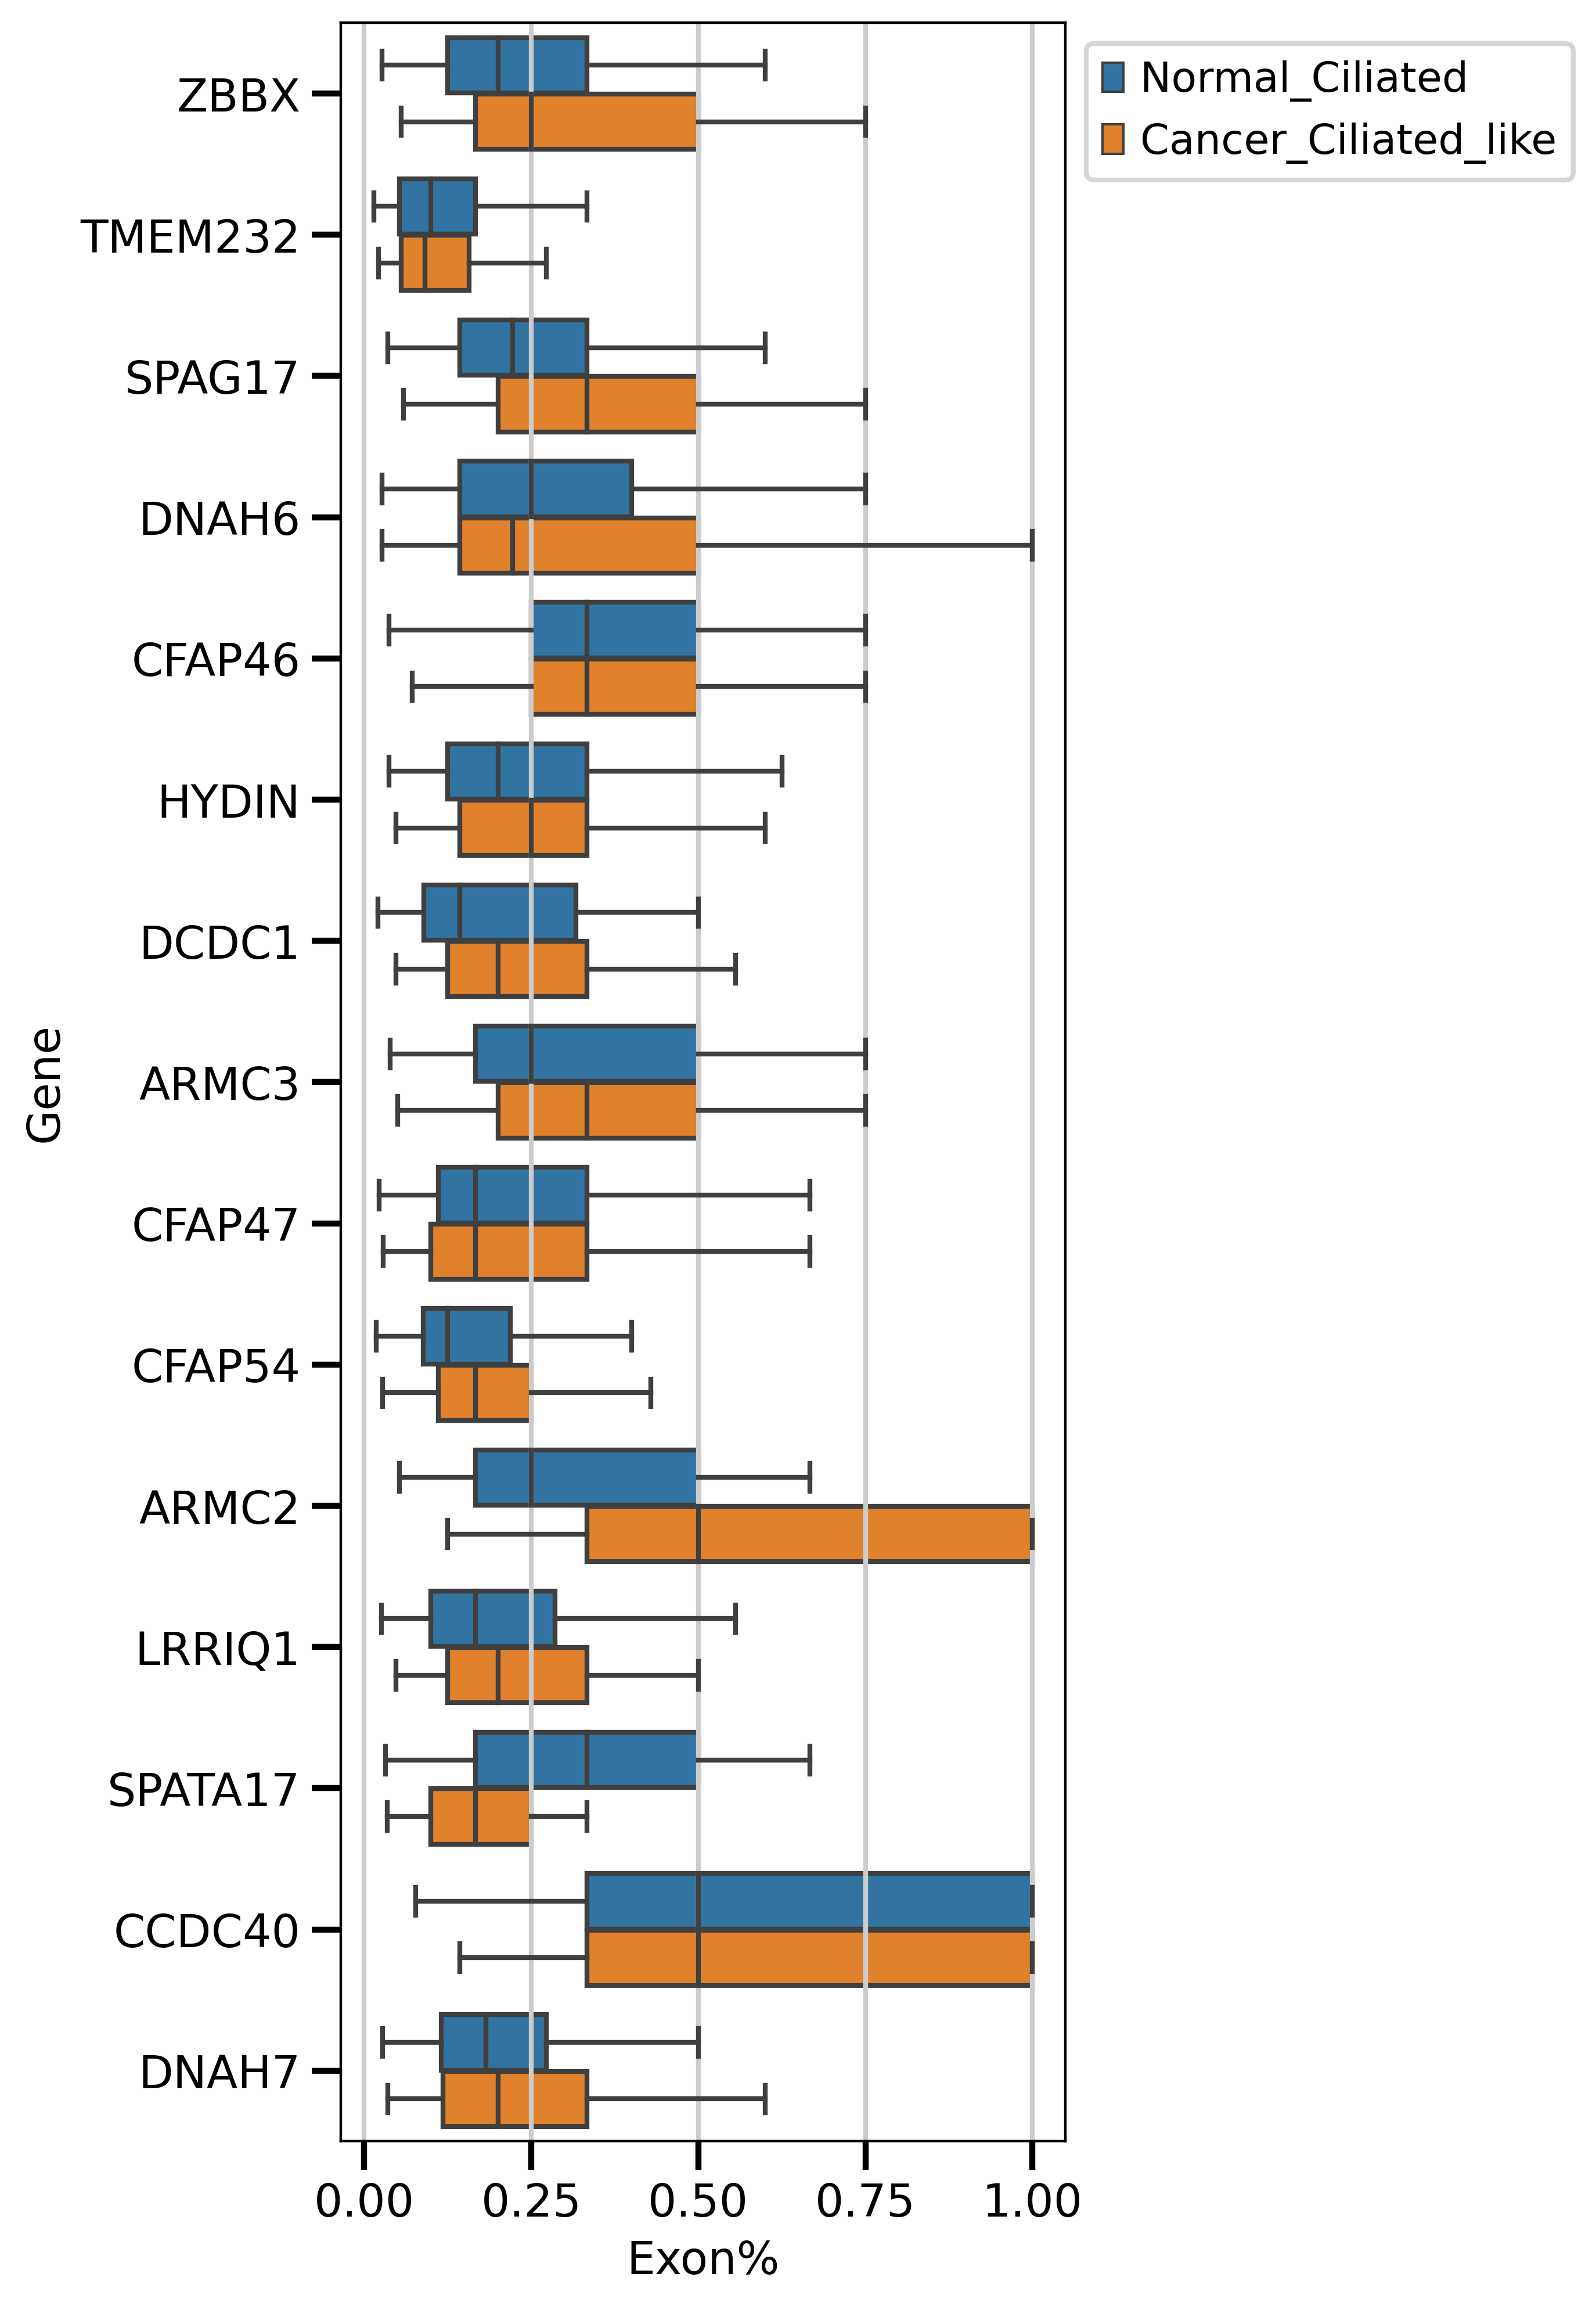

In [290]:
fig, axs = plt.subplots(1, 1, figsize = (4, 12), dpi = 200)
sns.boxplot(data=stat_all[stat_all['pct'] != 0], x='pct', y='gene', hue='Type', showfliers = False)
#plt.legend([], [], frameon=False)
plt.xlabel('Exon%')
plt.ylabel('Gene')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('figures/ciliated_gene_exon%.pdf')

In [291]:
normal_subset = stat_all[stat_all['Type'] == 'Normal_Ciliated'].copy()

normal_pct = pd.DataFrame(index=up_inter_deg_list)

for i in normal_pct.index.tolist():
    
    normal_pct.loc[i, 'all'] = normal_subset[normal_subset['gene'] == i].shape[0]
    normal_pct.loc[i, 'no_exp'] = normal_subset[(normal_subset['gene'] == i) & (normal_subset['exp'] == 'N')].shape[0]
    normal_pct.loc[i, 'intron_only'] = normal_subset[(normal_subset['gene'] == i) & (normal_subset['exp'] == 'Y') & (normal_subset['pct'] == 0)].shape[0]
    normal_pct.loc[i, 'exp'] = normal_subset[(normal_subset['gene'] == i) & (normal_subset['exp'] == 'Y') & (normal_subset['pct'] != 0)].shape[0]

normal_pct['No Expression'] = normal_pct['no_exp']/normal_pct['all']
normal_pct['Expressed(Intron Only)'] = normal_pct['intron_only']/normal_pct['all']
normal_pct['Expressed'] = normal_pct['exp']/normal_pct['all']

del normal_pct['all']
del normal_pct['no_exp']
del normal_pct['intron_only']
del normal_pct['exp']

normal_pct_final = normal_pct.copy()

normal_subset = stat_all[stat_all['Type'] == 'Cancer_Ciliated_like'].copy()

normal_pct = pd.DataFrame(index=up_inter_deg_list)

for i in normal_pct.index.tolist():
    
    normal_pct.loc[i, 'all'] = normal_subset[normal_subset['gene'] == i].shape[0]
    normal_pct.loc[i, 'no_exp'] = normal_subset[(normal_subset['gene'] == i) & (normal_subset['exp'] == 'N')].shape[0]
    normal_pct.loc[i, 'intron_only'] = normal_subset[(normal_subset['gene'] == i) & (normal_subset['exp'] == 'Y') & (normal_subset['pct'] == 0)].shape[0]
    normal_pct.loc[i, 'exp'] = normal_subset[(normal_subset['gene'] == i) & (normal_subset['exp'] == 'Y') & (normal_subset['pct'] != 0)].shape[0]

normal_pct['No Expression'] = normal_pct['no_exp']/normal_pct['all']
normal_pct['Expressed(Intron Only)'] = normal_pct['intron_only']/normal_pct['all']
normal_pct['Expressed'] = normal_pct['exp']/normal_pct['all']

del normal_pct['all']
del normal_pct['no_exp']
del normal_pct['intron_only']
del normal_pct['exp']

cancer_pct_final = normal_pct.copy()

normal_pct_final['Type'] = normal_pct_final.index + ' (Normal)'
cancer_pct_final['Type'] = cancer_pct_final.index + ' (Cancer)'

sorted_df = pd.DataFrame()

for i in list(range(0, len(up_inter_deg_list))):
    
    sorted_df = pd.concat([sorted_df, normal_pct_final[i:i+1]], axis=0)
    sorted_df = pd.concat([sorted_df, cancer_pct_final[i:i+1]], axis=0)
#all_final = pd.concat()

sorted_df.index = sorted_df['Type']

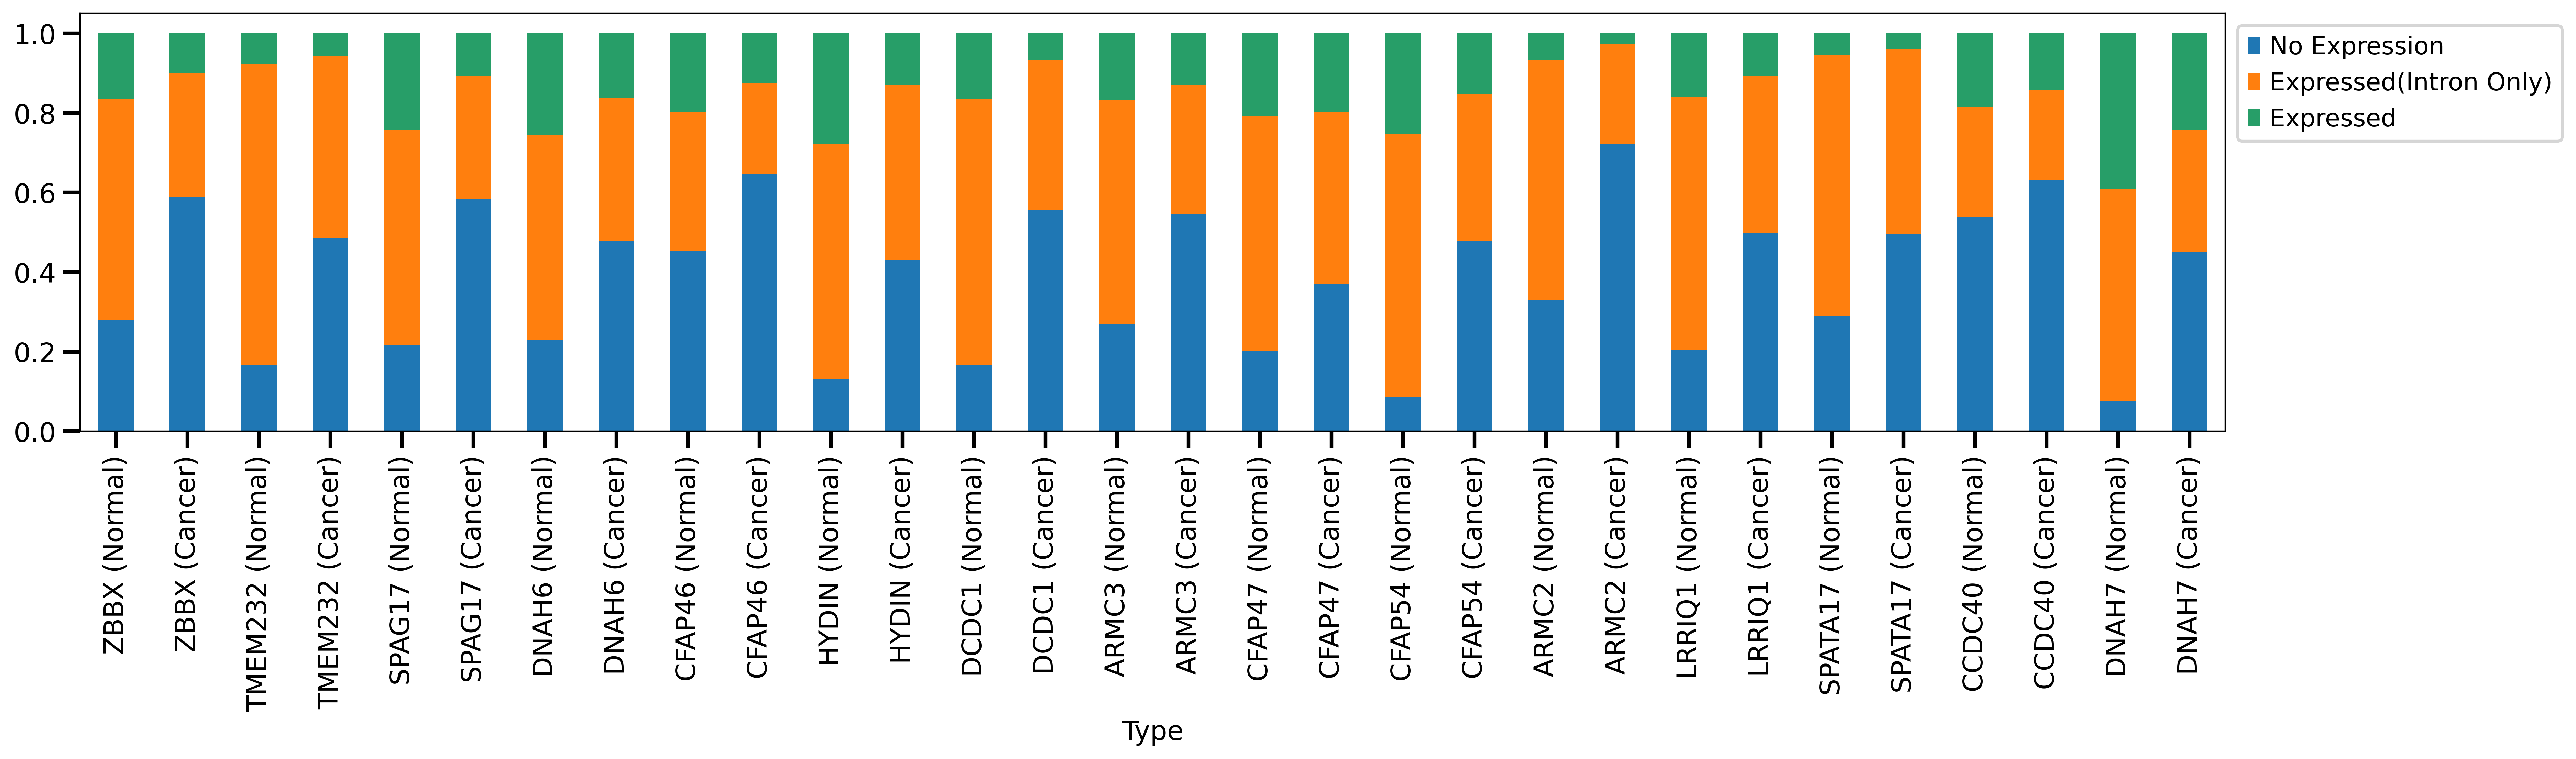

In [292]:
with plt.rc_context({"figure.figsize": (20, 4), "figure.dpi": (200)}):
    sorted_df.plot(kind = 'bar', stacked = True)
    plt.grid(False)
#    plt.axis('off')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.savefig('figures/cancer_normal_exp%.pdf')